# Preprocess

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/ML"
# configurations
data_DIR = '/content/drive/My Drive/Colab Notebooks/1092ML-FinalProject'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ls: cannot access '/content/drive/My Drive/ML': No such file or directory


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
from scipy import stats

In [ ]:
Pair = pd.read_csv("/content/drive/My Drive/Colab Notebooks/1092ML-FinalProject/glucose_insulin_pair.csv")
adm = pd.read_csv("/content/drive/My Drive/Colab Notebooks/1092ML-FinalProject/MIMIC3.1.4/ADMISSIONS.csv")
pt = pd.read_csv("/content/drive/My Drive/Colab Notebooks/1092ML-FinalProject/MIMIC3.1.4/PATIENTS.csv")
diag = pd.read_csv("/content/drive/My Drive/Colab Notebooks/1092ML-FinalProject/MIMIC3.1.4/DIAGNOSES_ICD.csv") 
# stay = pd.read_csv("/content/drive/My Drive/Colab Notebooks/1092ML-FinalProject/MIMIC3.1.4/ICUSTAYS.csv") 

print(Pair.shape)

(603764, 21)


In [ ]:
Pair.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'LOS_ICU_days', 'first_ICU_stay',
       'TIMER', 'STARTTIME', 'INPUT', 'INPUT_HRS', 'ENDTIME', 'INSULINTYPE',
       'EVENT', 'INFXSTOP', 'GLCTIMER', 'GLC', 'GLCSOURCE', 'GLCTIMER_AL',
       'GLC_AL', 'GLCSOURCE_AL', 'RULE', 'Repeated'],
      dtype='object')

### Combine with ADMISSIONS, PATIENTS<br>

##### merge pt and adm, and calculate age

In [ ]:
pt = pt.sort_values(by='SUBJECT_ID', ascending=True)
adm = adm.sort_values(by='SUBJECT_ID', ascending=True)

In [ ]:
adm_pt = adm.merge(pt, how='left', on='SUBJECT_ID')
print(adm_pt.shape)
# print(adm_pt.isnull().sum())
adm_pt.head()

(58976, 26)


,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,1,M,2138-07-17 00:00:00,NaN,NaN,NaN,0
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1,2,M,2025-04-11 00:00:00,2102-06-14 00:00:00,NaN,2102-06-14 00:00:00,1
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,3,F,2143-05-12 00:00:00,NaN,NaN,NaN,0
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,4,M,2103-02-02 00:00:00,NaN,NaN,NaN,0
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,5,F,2109-06-21 00:00:00,NaN,NaN,NaN,0


In [ ]:
adm_pt[['Ymd','HMS']] = adm_pt.ADMITTIME.str.split(' ',expand=True)
adm_pt[['Year', 'Month','Date']] = adm_pt.Ymd.str.split( '-',expand=True)
adm_pt['MD'] = adm_pt['Month']+'-'+ adm_pt['Date']
# adm_pt['ADMITE_datetime'] = adm_pt['Year']+ '-' + adm_pt['MD']+' '+adm_pt['HMS']
adm_pt['ADMITE_datetime'] = adm_pt['Year']+ '-' + adm_pt['MD']
# adm_pt['ADMITE_datetime'] = pd.to_datetime(adm_pt['ADMITE_datetime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
adm_pt['ADMITE_datetime'] = pd.to_datetime(adm_pt['ADMITE_datetime'], format='%Y-%m-%d', errors='coerce')
adm_pt = adm_pt.drop(['Ymd', 'HMS', 'Year', 'Month', 'Date', 'MD'], axis=1)

adm_pt[['Ymd','HMS']] = adm_pt.DOB.str.split(' ',expand=True)
adm_pt[['Year', 'Month','Date']] = adm_pt.Ymd.str.split( '-',expand=True)
adm_pt['MD'] = adm_pt['Month']+'-'+ adm_pt['Date']
adm_pt['DOB_datetime'] = adm_pt['Year']+ '-' + adm_pt['MD']
adm_pt['DOB_datetime'] = pd.to_datetime(adm_pt['DOB_datetime'], format='%Y-%m-%d', errors='coerce')
adm_pt = adm_pt.drop(['Ymd', 'HMS', 'Year', 'Month', 'Date', 'MD'], axis=1)

adm_pt.head()

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ADMITE_datetime,DOB_datetime
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,1,M,2138-07-17 00:00:00,NaN,NaN,NaN,0,2138-07-17,2138-07-17
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1,2,M,2025-04-11 00:00:00,2102-06-14 00:00:00,NaN,2102-06-14 00:00:00,1,2101-10-20,2025-04-11
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,3,F,2143-05-12 00:00:00,NaN,NaN,NaN,0,2191-03-16,2143-05-12
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,4,M,2103-02-02 00:00:00,NaN,NaN,NaN,0,2103-02-02,2103-02-02
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,5,F,2109-06-21 00:00:00,NaN,NaN,NaN,0,2175-05-30,2109-06-21


In [ ]:
from dateutil.relativedelta import relativedelta
adm_pt['age']=np.nan
for i in adm_pt.index: 
  adm_pt['age'][i] = (relativedelta(adm_pt['ADMITE_datetime'][i], adm_pt['DOB_datetime'][i])).years
# adm_pt.head()

In [ ]:
conditions = [
    (adm_pt['age'] < 18),
    ((adm_pt['age'] <= 65) & (adm_pt['age'] >=18)),
    (adm_pt['age'] >65)
    ]
values = [0,1,2]
adm_pt['age_group']=np.nan
adm_pt['age_group'] = np.select(conditions, values)
adm_pt.head()

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ADMITE_datetime,DOB_datetime,age,age_group
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,1,M,2138-07-17 00:00:00,NaN,NaN,NaN,0,2138-07-17,2138-07-17,0.0,0
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1,2,M,2025-04-11 00:00:00,2102-06-14 00:00:00,NaN,2102-06-14 00:00:00,1,2101-10-20,2025-04-11,76.0,2
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,3,F,2143-05-12 00:00:00,NaN,NaN,NaN,0,2191-03-16,2143-05-12,47.0,1
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,4,M,2103-02-02 00:00:00,NaN,NaN,NaN,0,2103-02-02,2103-02-02,0.0,0
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,5,F,2109-06-21 00:00:00,NaN,NaN,NaN,0,2175-05-30,2109-06-21,65.0,1


In [ ]:
# merge with Pair
cols = ['HADM_ID', 'GENDER', 'ADMISSION_TYPE', 'age', 'age_group', 'DOD_HOSP','HOSPITAL_EXPIRE_FLAG']
adm_pt = adm_pt[cols]
df1 = Pair.merge(adm_pt, how='left', on='HADM_ID')
print(Pair.shape)
print(df1.shape)

(603764, 21)
(603764, 27)


### DIAGNOSIS

In [ ]:
# find DM patients
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/1092ML-FinalProject/DM.txt", sep="\t")
DM_ID = list(df.b.values)

cols=['SUBJECT_ID', 'SEQ_NUM', 'ICD9_CODE']
diag = diag[cols]

diag = diag.sort_values(by='SUBJECT_ID', ascending = True)
Pair = Pair.sort_values(by='SUBJECT_ID', ascending = True)
df3 = Pair.merge(diag, how='left', on='SUBJECT_ID')

L = DM_ID
df3['DM'] = np.where(df3['ICD9_CODE'].isin(L), 1,0)
df3.head()

# find pt with DM
df4 = df3[df3.DM ==1]
print(df4.shape)
DM_pt = list(df4.HADM_ID.unique())
print(len(DM_pt))


(1108115, 24)
5610


In [ ]:
L = DM_pt
df1['DM'] = np.where(df1['HADM_ID'].isin(L), 1,0)

### Replace value

In [ ]:
# binary
df1=df1.replace({'ADMISSION_TYPE': {'EMERGENCY': 1, 'ELECTIVE': 0, 'URGENT':0}})
df1=df1.replace({'GENDER': {'M': 1, 'F': 0}})
df1=df1.replace({'GLCSOURCE': {'FINGERSTICK': 0, 'BLOOD': 1}})
df1['Repeated'] = df1['Repeated'].fillna(value=0)

# categorical
df1=df1.replace({'INSULINTYPE': {'Short': 0, 'Intermediate': 1, 'Long': 2}})
df1=df1.replace({'EVENT': {'BOLUS_PUSH': 0, 'BOLUS_INYECTION': 1, 'INFUSION': 2}})
df1['RULE'] = df1['RULE'].fillna(value=0)

df1 = df1.sort_values(by=['HADM_ID', 'TIMER'], ascending=[True, True])
df1 = df1.drop(['ICUSTAY_ID', 'first_ICU_stay', 'GLCTIMER_AL', 'GLC_AL', 'GLCSOURCE_AL'], axis=1)
print(df1.shape)
print(df1.columns)


(603764, 23)
Index(['SUBJECT_ID', 'HADM_ID', 'LOS_ICU_days', 'TIMER', 'STARTTIME', 'INPUT',
       'INPUT_HRS', 'ENDTIME', 'INSULINTYPE', 'EVENT', 'INFXSTOP', 'GLCTIMER',
       'GLC', 'GLCSOURCE', 'RULE', 'Repeated', 'GENDER', 'ADMISSION_TYPE',
       'age', 'age_group', 'DOD_HOSP', 'HOSPITAL_EXPIRE_FLAG', 'DM'],
      dtype='object')


In [ ]:
df1.ADMISSION_TYPE.value_counts()

1    486919
0    116845
Name: ADMISSION_TYPE, dtype: int64

### Fill nan

In [ ]:
df2 = df1.sort_values(by=['HADM_ID', 'TIMER'], ascending = [True, True])
for col in ['INPUT', 'INPUT_HRS', 'INSULINTYPE', 'EVENT', 'GLC', 'GLCSOURCE']:
    df2[col] = df2[col].ffill()
for col in ['GLC', 'GLCSOURCE']:
    df2[col] = df2[col].bfill()

In [ ]:
df2.isnull().sum()

SUBJECT_ID                   0
HADM_ID                      0
LOS_ICU_days                 0
TIMER                        0
STARTTIME               458086
INPUT                        0
INPUT_HRS                    0
ENDTIME                 458086
INSULINTYPE                  0
EVENT                        0
INFXSTOP                458086
GLCTIMER                145678
GLC                          0
GLCSOURCE                    0
RULE                         0
Repeated                     0
GENDER                       0
ADMISSION_TYPE               0
age                          0
age_group                    0
DOD_HOSP                421148
HOSPITAL_EXPIRE_FLAG         0
DM                           0
dtype: int64

### create label (days_output)



In [ ]:
# some HADM_ID have two values for LOS_ICU_days, here we only keep the largest value as the outcome
b = {}
for i in df2.HADM_ID.unique():
    b[i] = pd.concat([df2[df2['HADM_ID']==i]],axis=0, ignore_index=True)
    n = b[i].LOS_ICU_days.unique()
    # print(n)
    m = max(n)
    # print(m)
    b[i] = b[i][b[i]['LOS_ICU_days']==m]


df2_drop = pd.concat(b.values(), ignore_index=True)

In [ ]:
print(df2.HADM_ID.nunique())
print(df2.shape)
print(df2_drop.HADM_ID.nunique())
print(df2_drop.shape)

11094
(603764, 22)
11094
(581979, 22)


Text(0, 0.5, 'Frequency')

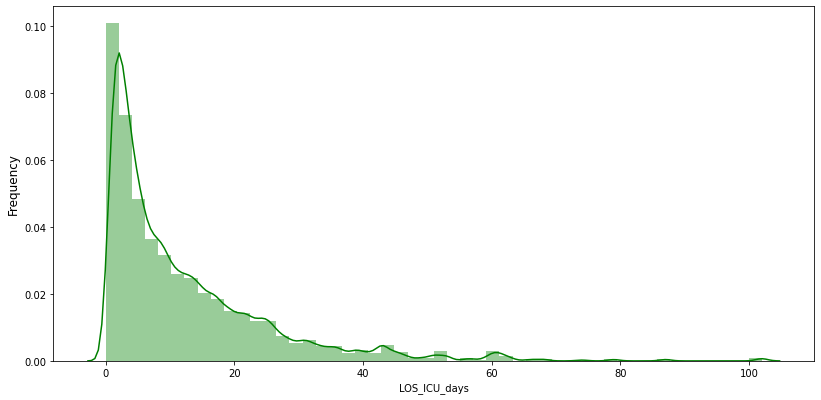

In [ ]:
# visualize label distribution
plt.figure(figsize=(30,30))

plt.subplot(4,2,1)
sns.distplot(df2_drop['LOS_ICU_days'], color='green')
plt.ylabel('Frequency', fontsize=12)

In [ ]:
conditions = [
    (df2_drop['LOS_ICU_days'] <= 3),
    ((df2_drop['LOS_ICU_days'] >3))
    ]
values = [0,1]
df2_drop['days_output']=0
df2_drop['days_output'] = np.select(conditions, values)

In [ ]:
df2_drop.days_output.value_counts()
print("perventage of label 0:", 169945/412034) 

perventage of label 0: 0.41245382662595803


In [ ]:
df2_drop.to_csv(r'/content/drive/My Drive/Colab Notebooks/1092ML-FinalProject/df2_drop.csv')

# Create datasets

## ADULTS & ELDERLY

In [ ]:
df2_drop=pd.read_csv('/content/drive/My Drive/Colab Notebooks/1092ML-FinalProject/df2_drop.csv')

In [ ]:
df2_drop.columns

Index(['SUBJECT_ID', 'HADM_ID', 'LOS_ICU_days', 'TIMER', 'STARTTIME', 'INPUT',
       'INPUT_HRS', 'ENDTIME', 'INSULINTYPE', 'EVENT', 'INFXSTOP', 'GLCTIMER',
       'GLC', 'GLCSOURCE', 'RULE', 'Repeated', 'GENDER', 'ADMISSION_TYPE',
       'age', 'age_group', 'DOD_HOSP', 'HOSPITAL_EXPIRE_FLAG', 'DM',
       'days_output'],
      dtype='object')

In [ ]:
L=[1,2]
df2_drop = df2_drop[df2_drop['age_group'].isin(L)]

cols=['HADM_ID', 'TIMER', 'INPUT', 'INPUT_HRS','INSULINTYPE', 'EVENT', 'GLC', 'GLCSOURCE', 'ADMISSION_TYPE', 'GENDER', 'age_group', 'DM', 'RULE', 'Repeated', 'LOS_ICU_days', 'days_output']
df2_drop = df2_drop[cols]

In [ ]:
df2_drop.age_group.value_counts()

1    294020
2    287605
Name: age_group, dtype: int64

##### calculate repeated rows<br> (for ML, exploratory data analysis and statistical analysis)

In [ ]:
length=[]
b = {}
for i in df2_drop.HADM_ID.unique():
    b[i] = pd.concat([df2_drop[df2_drop['HADM_ID']==i]],axis=0, ignore_index=True)
    length.append(len(b[i]))
    b[i]['C'] = np.arange(len(b[i]))

df_all = pd.concat(b.values(), ignore_index=True)

##### expand rows so each HADM_ID has same number of rows (for DL)

In [ ]:
print(df_all['C'].max())
print(df_all['HADM_ID'].nunique())

1155
11084


In [ ]:
iterables = [df_all['HADM_ID'].unique(),df_all['C'].unique()]
df_all_1 = df_all.set_index(['HADM_ID','C'])
df_all_1 = df_all_1.reindex(index=pd.MultiIndex.from_product(iterables, names=['HADM_ID','C']), fill_value=0).reset_index()
df_all_1.shape

(12813104, 17)

In [ ]:
df_all_1.HADM_ID.nunique()

11084

In [ ]:
df_all.to_csv(r'/content/drive/My Drive/Colab Notebooks/1092ML-FinalProject/df(EDA)-all-0619.csv')
df_all_1.to_csv(r'/content/drive/My Drive/Colab Notebooks/1092ML-FinalProject/df(expand)-all-0619.csv')

## ADULTS

In [ ]:
df5 = df2_drop[df2_drop['age_group']==1]
cols=['HADM_ID', 'TIMER', 'INPUT', 'INPUT_HRS','INSULINTYPE', 'EVENT', 'GLC', 'GLCSOURCE', 'ADMISSION_TYPE', 'GENDER', 'age_group', 'DM', 'RULE', 'Repeated', 'LOS_ICU_days', 'days_output']
df5 = df5[cols]

##### calculate repeated rows<br> (for ML, exploratory data analysis and statistical analysis)

In [ ]:
df5 = df5.sort_values(by=['HADM_ID', 'TIMER'], ascending=[True, True])

In [ ]:
length=[]
b = {}
for i in df5.HADM_ID.unique():
    b[i] = pd.concat([df5[df5['HADM_ID']==i]],axis=0, ignore_index=True)
    length.append(len(b[i]))
    b[i]['C'] = np.arange(len(b[i]))

df6 = pd.concat(b.values(), ignore_index=True)

In [ ]:
df6.head()

##### expand rows so each HADM_ID has same number of rows (for DL)

In [ ]:
print(df6['C'].max())
print(df6['HADM_ID'].nunique())

1155
5342


In [ ]:
iterables = [df6['HADM_ID'].unique(),df6['C'].unique()]
df7 = df6.set_index(['HADM_ID','C'])
df7 = df7.reindex(index=pd.MultiIndex.from_product(iterables, names=['HADM_ID','C']), fill_value=0).reset_index()
df7.shape

(6175352, 17)

In [ ]:
# df6.to_csv(r'/content/drive/My Drive/Colab Notebooks/1092ML-FinalProject/df6(ML)-adult-0619.csv')
df7.to_csv(r'/content/drive/My Drive/Colab Notebooks/1092ML-FinalProject/df7(expand)-adult-0619.csv')

## ELEDERLY

In [ ]:
df2_drop=pd.read_csv('/content/drive/My Drive/Colab Notebooks/1092ML-FinalProject/df2_drop.csv')

In [ ]:
df2_drop.age_group.value_counts()

1    294020
2    287605
0       354
Name: age_group, dtype: int64

In [ ]:
df8 = df2_drop[df2_drop['age_group']==2]
cols=['HADM_ID', 'TIMER', 'INPUT', 'INPUT_HRS','INSULINTYPE', 'EVENT', 'GLC', 'GLCSOURCE', 'ADMISSION_TYPE', 'GENDER', 'age_group', 'DM', 'RULE', 'Repeated', 'LOS_ICU_days', 'days_output']
df8 = df8[cols]

#####calculate repeated rows <br>
(for ML, exploratory data analysis and statistical analysis)

In [ ]:
df8 = df8.sort_values(by=['HADM_ID', 'TIMER'], ascending=[True, True])

In [ ]:
length=[]
b = {}
for i in df8.HADM_ID.unique():
    b[i] = pd.concat([df8[df8['HADM_ID']==i]],axis=0, ignore_index=True)
    length.append(len(b[i]))
    b[i]['C'] = np.arange(len(b[i]))

df9 = pd.concat(b.values(), ignore_index=True)

##### expand rows so each HADM_ID has same number of rows (for DL)

In [ ]:
print(df9['C'].max())
print(df9['HADM_ID'].nunique())

876
5742


In [ ]:
iterables = [df9['HADM_ID'].unique(),df9['C'].unique()]
df10 = df9.set_index(['HADM_ID','C'])
df10 = df10.reindex(index=pd.MultiIndex.from_product(iterables, names=['HADM_ID','C']), fill_value=0).reset_index()
df10.shape

(5035734, 17)

In [ ]:
877*5742

5035734

In [ ]:
# df9.to_csv(r'/content/drive/My Drive/Colab Notebooks/1092ML-FinalProject/df6(ML)-elderly-0619.csv')
df10.to_csv(r'/content/drive/My Drive/Colab Notebooks/1092ML-FinalProject/df7(expand)-elderly-0619.csv')